# Track A: Validación Daily OHLCV Pipeline

**Autor**: Data Science Team

**Fecha**: 2025-10-28

**Objetivo**: Validación exhaustiva del pipeline de agregación 1m → Daily OHLCV para Track A (Event Detectors E1/E4/E7/E8)

---

## Executive Summary

Este notebook valida de forma rigurosa:

1. **Cobertura y completitud del dataset**
2. **Estructura y schema de datos**
3. **Calidad de los datos (nulls, duplicados, outliers)**
4. **Integridad OHLC (reglas de mercado)**
5. **Corrección de agregación** (comparación vs fuente)
6. **Distribuciones estadísticas**
7. **Time series properties**
8. **Recomendaciones y siguientes pasos**

---

In [1]:
import polars as pl
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, date
import warnings
warnings.filterwarnings('ignore')

# Configuración
sns.set_theme(style='whitegrid', palette='husl')
pl.Config.set_tbl_rows(10)
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

# Rutas
DAILY_OHLCV_ROOT = Path('D:/04_TRADING_SMALLCAPS/processed/daily_ohlcv')
INTRADAY_1M_ROOT = Path('D:/04_TRADING_SMALLCAPS/raw/polygon/ohlcv_intraday_1m')

print('✅ Environment configurado')
print(f'   Daily OHLCV: {DAILY_OHLCV_ROOT}')
print(f'   Intraday 1m: {INTRADAY_1M_ROOT}')

✅ Environment configurado
   Daily OHLCV: D:\04_TRADING_SMALLCAPS\processed\daily_ohlcv
   Intraday 1m: D:\04_TRADING_SMALLCAPS\raw\polygon\ohlcv_intraday_1m


## 1. Data Discovery: Estructura y Cobertura

In [2]:
# Descubrir estructura
ticker_dirs = [d for d in DAILY_OHLCV_ROOT.iterdir() if d.is_dir()]

print("=" * 80)
print("1.1 ESTRUCTURA DE DIRECTORIOS")
print("=" * 80)
print()
print(f"Total tickers procesados: {len(ticker_dirs):,}")
print(f"Tickers esperados: 8,620")
print(f"Coverage: {len(ticker_dirs)/8620*100:.2f}%")
print()

# Analizar estructura de archivos
with_parquet = 0
with_success = 0
with_both = 0
empty_dirs = 0

for ticker_dir in ticker_dirs:
    has_parquet = (ticker_dir / 'daily.parquet').exists()
    has_success = (ticker_dir / '_SUCCESS').exists()
    
    if has_parquet and has_success:
        with_both += 1
    elif has_parquet:
        with_parquet += 1
    elif has_success:
        with_success += 1
    else:
        empty_dirs += 1

print("Distribución de archivos:")
print(f"  daily.parquet + _SUCCESS: {with_both:,} ({with_both/len(ticker_dirs)*100:.2f}%)")
print(f"  Solo daily.parquet: {with_parquet:,}")
print(f"  Solo _SUCCESS: {with_success:,}")
print(f"  Directorios vacíos: {empty_dirs:,}")
print()
print(f"✅ Tickers válidos: {with_both:,}")

1.1 ESTRUCTURA DE DIRECTORIOS

Total tickers procesados: 8,617
Tickers esperados: 8,620
Coverage: 99.97%



Distribución de archivos:
  daily.parquet + _SUCCESS: 8,617 (100.00%)
  Solo daily.parquet: 0
  Solo _SUCCESS: 0
  Directorios vacíos: 0

✅ Tickers válidos: 8,617


In [3]:
print("=" * 80)
print("1.2 EJEMPLO DE ESTRUCTURA FÍSICA")
print("=" * 80)
print()

# Seleccionar 3 tickers aleatorios
import random
random.seed(42)
sample_dirs = random.sample([d for d in ticker_dirs if (d/'daily.parquet').exists()], 3)

for ticker_dir in sample_dirs:
    print(f"Ticker: {ticker_dir.name}")
    print(f"  Ubicación: {ticker_dir.relative_to(DAILY_OHLCV_ROOT.parent)}")
    
    # Listar archivos y tamaños
    for file in ticker_dir.iterdir():
        size_kb = file.stat().st_size / 1024
        print(f"  ├─ {file.name:20s} ({size_kb:>8.2f} KB)")
    
    print()

1.2 EJEMPLO DE ESTRUCTURA FÍSICA



Ticker: SOCA
  Ubicación: daily_ohlcv\SOCA
  ├─ daily.parquet        (    3.73 KB)
  ├─ _SUCCESS             (    0.00 KB)

Ticker: NKTX
  Ubicación: daily_ohlcv\NKTX
  ├─ daily.parquet        (   39.51 KB)
  ├─ _SUCCESS             (    0.00 KB)

Ticker: DWRE
  Ubicación: daily_ohlcv\DWRE
  ├─ daily.parquet        (   32.63 KB)
  ├─ _SUCCESS             (    0.00 KB)



## 2. Schema y Tipado de Datos

In [4]:
print("=" * 80)
print("2.1 SCHEMA ANALYSIS")
print("=" * 80)
print()

# Expected schema
EXPECTED_SCHEMA = {
    'ticker': pl.Utf8,
    'date': pl.Date,
    'o': pl.Float64,
    'h': pl.Float64,
    'l': pl.Float64,
    'c': pl.Float64,
    'v': pl.Float64,
    'n': pl.Int64,
    'dollar': pl.Float64
}

print("Expected Schema:")
print(f"  Columns: {len(EXPECTED_SCHEMA)}")
for col, dtype in EXPECTED_SCHEMA.items():
    print(f"  ├─ {col:10s}: {dtype}")
print()

# Verificar contra 20 tickers aleatorios
sample_tickers = random.sample([d for d in ticker_dirs if (d/'daily.parquet').exists()], min(20, len(ticker_dirs)))

schema_matches = 0
schema_mismatches = []

for ticker_dir in sample_tickers:
    df = pl.read_parquet(ticker_dir / 'daily.parquet')
    
    if df.schema == EXPECTED_SCHEMA:
        schema_matches += 1
    else:
        schema_mismatches.append({
            'ticker': ticker_dir.name,
            'schema': df.schema
        })

print(f"Schema validation (n={len(sample_tickers)}):")
print(f"  ✅ Matches: {schema_matches}/{len(sample_tickers)}")
print(f"  ❌ Mismatches: {len(schema_mismatches)}/{len(sample_tickers)}")
print()

if schema_mismatches:
    print("⚠️  Schema mismatches found:")
    for mismatch in schema_mismatches[:3]:
        print(f"  Ticker: {mismatch['ticker']}")
        print(f"  Schema: {mismatch['schema']}")
else:
    print("✅ ALL schemas match expected structure")

2.1 SCHEMA ANALYSIS

Expected Schema:
  Columns: 9
  ├─ ticker    : String
  ├─ date      : Date
  ├─ o         : Float64
  ├─ h         : Float64
  ├─ l         : Float64
  ├─ c         : Float64
  ├─ v         : Float64
  ├─ n         : Int64
  ├─ dollar    : Float64



Schema validation (n=20):
  ✅ Matches: 20/20
  ❌ Mismatches: 0/20

✅ ALL schemas match expected structure


## 3. Contenido Interno: Deep Dive en los Datos

In [5]:
print("=" * 80)
print("3.1 DEEP DIVE: CONTENIDO REAL DE 3 TICKERS")
print("=" * 80)
print()

for ticker_dir in sample_dirs:
    ticker = ticker_dir.name
    df = pl.read_parquet(ticker_dir / 'daily.parquet')
    
    print(f"\n{'=' * 80}")
    print(f"TICKER: {ticker}")
    print(f"{'=' * 80}\n")
    
    # Metadata básica
    print(f"📊 METADATA:")
    print(f"  Total días: {len(df):,}")
    print(f"  Fecha inicio: {df['date'].min()}")
    print(f"  Fecha fin: {df['date'].max()}")
    print(f"  Días totales: {(df['date'].max() - df['date'].min()).days}")
    print(f"  Tamaño en memoria: {df.estimated_size() / 1024:.2f} KB")
    print()
    
    # Primeras 5 filas
    print(f"📄 PRIMERAS 5 FILAS:")
    print(df.head(5))
    print()
    
    # Últimas 5 filas
    print(f"📄 ÚLTIMAS 5 FILAS:")
    print(df.tail(5))
    print()
    
    # Estadísticas descriptivas
    print(f"📈 ESTADÍSTICAS DESCRIPTIVAS:")
    print(df.select(['o', 'h', 'l', 'c', 'v', 'n', 'dollar']).describe())
    print()
    
    # Día con mayor volumen
    max_vol_day = df.filter(pl.col('v') == pl.col('v').max())
    print(f"🔥 DÍA CON MAYOR VOLUMEN:")
    print(max_vol_day)
    print()

3.1 DEEP DIVE: CONTENIDO REAL DE 3 TICKERS


TICKER: SOCA

📊 METADATA:
  Total días: 31
  Fecha inicio: 2025-09-05
  Fecha fin: 2025-10-21
  Días totales: 46
  Tamaño en memoria: 1.94 KB

📄 PRIMERAS 5 FILAS:
shape: (5, 9)
┌────────┬────────────┬──────┬───────┬───┬───────┬──────────┬─────┬───────────┐
│ ticker ┆ date       ┆ o    ┆ h     ┆ … ┆ c     ┆ v        ┆ n   ┆ dollar    │
│ ---    ┆ ---        ┆ ---  ┆ ---   ┆   ┆ ---   ┆ ---      ┆ --- ┆ ---       │
│ str    ┆ date       ┆ f64  ┆ f64   ┆   ┆ f64   ┆ f64      ┆ i64 ┆ f64       │
╞════════╪════════════╪══════╪═══════╪═══╪═══════╪══════════╪═════╪═══════════╡
│ SOCA   ┆ 2025-09-05 ┆ 9.96 ┆ 10.0  ┆ … ┆ 9.9   ┆ 501513.0 ┆ 208 ┆ 5.0034e6  │
│ SOCA   ┆ 2025-09-08 ┆ 9.96 ┆ 9.96  ┆ … ┆ 9.945 ┆ 1300.0   ┆ 3   ┆ 12943.5   │
│ SOCA   ┆ 2025-09-09 ┆ 9.94 ┆ 9.96  ┆ … ┆ 9.96  ┆ 850000.0 ┆ 5   ┆ 8.454e6   │
│ SOCA   ┆ 2025-09-10 ┆ 9.97 ┆ 9.975 ┆ … ┆ 9.97  ┆ 31226.0  ┆ 36  ┆ 311323.22 │
│ SOCA   ┆ 2025-09-11 ┆ 9.97 ┆ 9.97  ┆ … ┆ 9.97  ┆ 699432.

## 4. Data Quality: NULLs, Duplicados, Outliers

In [6]:
print("=" * 80)
print("4.1 DATA QUALITY ASSESSMENT (sample 50 tickers)")
print("=" * 80)
print()

sample_quality = random.sample([d for d in ticker_dirs if (d/'daily.parquet').exists()], min(50, len(ticker_dirs)))

# Contadores
null_counts = {col: 0 for col in EXPECTED_SCHEMA.keys()}
duplicate_dates = 0
unordered_dates = 0
negative_values = {'o': 0, 'h': 0, 'l': 0, 'c': 0, 'v': 0, 'n': 0, 'dollar': 0}
zero_volume = 0
total_rows = 0

for ticker_dir in sample_quality:
    df = pl.read_parquet(ticker_dir / 'daily.parquet')
    total_rows += len(df)
    
    # NULLs
    for col in EXPECTED_SCHEMA.keys():
        null_counts[col] += df[col].is_null().sum()
    
    # Duplicados
    if df['date'].n_unique() < len(df):
        duplicate_dates += 1
    
    # Orden
    dates = df['date'].to_list()
    if dates != sorted(dates):
        unordered_dates += 1
    
    # Valores negativos
    for col in ['o', 'h', 'l', 'c', 'v', 'n', 'dollar']:
        if df[col].min() < 0:
            negative_values[col] += 1
    
    # Volumen cero
    if df.filter(pl.col('v') == 0).height > 0:
        zero_volume += 1

print(f"Sample size: {len(sample_quality)} tickers, {total_rows:,} rows\n")

print("NULL VALUES:")
total_nulls = sum(null_counts.values())
for col, count in null_counts.items():
    pct = (count / total_rows * 100) if total_rows > 0 else 0
    print(f"  {col:10s}: {count:>6,} ({pct:>6.3f}%)")
print(f"  TOTAL: {total_nulls:>6,}\n")

print("DUPLICATE DATES:")
print(f"  Tickers con duplicados: {duplicate_dates}/{len(sample_quality)}\n")

print("TEMPORAL ORDER:")
print(f"  Tickers desordenados: {unordered_dates}/{len(sample_quality)}\n")

print("NEGATIVE VALUES:")
for col, count in negative_values.items():
    print(f"  {col:10s}: {count} tickers")
print()

print("ZERO VOLUME DAYS:")
print(f"  Tickers con volumen=0: {zero_volume}/{len(sample_quality)}\n")

# Resumen
issues = total_nulls + duplicate_dates + unordered_dates + sum(negative_values.values())
if issues == 0:
    print("✅ DATA QUALITY: EXCELLENT (no issues found)")
else:
    print(f"⚠️  DATA QUALITY: {issues} issues found")

4.1 DATA QUALITY ASSESSMENT (sample 50 tickers)



Sample size: 50 tickers, 84,081 rows

NULL VALUES:
  ticker    :      0 ( 0.000%)
  date      :      0 ( 0.000%)
  o         :      0 ( 0.000%)
  h         :      0 ( 0.000%)
  l         :      0 ( 0.000%)
  c         :      0 ( 0.000%)
  v         :      0 ( 0.000%)
  n         :      0 ( 0.000%)
  dollar    :      0 ( 0.000%)
  TOTAL:      0

DUPLICATE DATES:
  Tickers con duplicados: 0/50

TEMPORAL ORDER:
  Tickers desordenados: 0/50

NEGATIVE VALUES:
  o         : 0 tickers
  h         : 0 tickers
  l         : 0 tickers
  c         : 0 tickers
  v         : 0 tickers
  n         : 0 tickers
  dollar    : 0 tickers

ZERO VOLUME DAYS:
  Tickers con volumen=0: 0/50

✅ DATA QUALITY: EXCELLENT (no issues found)


## 5. Integridad OHLC: Market Rules Validation

In [7]:
print("=" * 80)
print("5.1 OHLC INTEGRITY RULES")
print("=" * 80)
print()
print("Market rules:")
print("  1. high >= max(open, close)")
print("  2. low <= min(open, close)")
print("  3. high >= low")
print("  4. close > 0 (no negative prices)")
print()

violations = {'rule1': 0, 'rule2': 0, 'rule3': 0, 'rule4': 0}
total_rows_checked = 0

for ticker_dir in sample_quality:
    df = pl.read_parquet(ticker_dir / 'daily.parquet')
    total_rows_checked += len(df)
    
    # Rule 1: high >= max(open, close)
    v1 = df.filter(pl.col('h') < pl.max_horizontal('o', 'c'))
    violations['rule1'] += len(v1)
    
    # Rule 2: low <= min(open, close)
    v2 = df.filter(pl.col('l') > pl.min_horizontal('o', 'c'))
    violations['rule2'] += len(v2)
    
    # Rule 3: high >= low
    v3 = df.filter(pl.col('h') < pl.col('l'))
    violations['rule3'] += len(v3)
    
    # Rule 4: close > 0
    v4 = df.filter(pl.col('c') <= 0)
    violations['rule4'] += len(v4)

print(f"Rows checked: {total_rows_checked:,}\n")

print("VIOLATIONS:")
total_violations = sum(violations.values())
for rule, count in violations.items():
    pct = (count / total_rows_checked * 100) if total_rows_checked > 0 else 0
    print(f"  {rule}: {count:>6,} ({pct:>8.4f}%)")
print(f"  TOTAL: {total_violations:>6,}\n")

if total_violations == 0:
    print("✅ OHLC INTEGRITY: PERFECT (0 violations)")
else:
    print(f"❌ OHLC INTEGRITY: {total_violations:,} violations ({total_violations/total_rows_checked*100:.4f}%)")

5.1 OHLC INTEGRITY RULES

Market rules:
  1. high >= max(open, close)
  2. low <= min(open, close)
  3. high >= low
  4. close > 0 (no negative prices)



Rows checked: 84,081

VIOLATIONS:
  rule1:      0 (  0.0000%)
  rule2:      0 (  0.0000%)
  rule3:      0 (  0.0000%)
  rule4:      0 (  0.0000%)
  TOTAL:      0

✅ OHLC INTEGRITY: PERFECT (0 violations)


## 6. Agregación Correcta: Verificación Matemática vs Fuente

In [8]:
print("=" * 80)
print("6.1 AGGREGATION VERIFICATION (1m → Daily)")
print("=" * 80)
print()
print("Buscando 3 tickers con datos 1m disponibles...\n")

# Buscar 3 tickers que tengan datos 1m
test_tickers = []

for ticker_dir in sample_quality:
    if len(test_tickers) >= 3:
        break
    
    ticker = ticker_dir.name
    intraday_dir = INTRADAY_1M_ROOT / ticker
    
    if intraday_dir.exists():
        minute_files = list(intraday_dir.rglob('minute.parquet'))
        if len(minute_files) > 0:
            test_tickers.append({
                'ticker': ticker,
                'ticker_dir': ticker_dir,
                'intraday_dir': intraday_dir,
                'minute_files': minute_files
            })

if len(test_tickers) == 0:
    print("⚠️  No se encontraron tickers con datos 1m en el sample")
    print("   Skipping aggregation verification")
else:
    print(f"✅ Tickers seleccionados: {len(test_tickers)}\n")
    
    # Procesar cada ticker
    for test_info in test_tickers:
        ticker = test_info['ticker']
        ticker_dir = test_info['ticker_dir']
        minute_files = test_info['minute_files']
        
        print("=" * 80)
        print(f"TICKER: {ticker}")
        print("=" * 80)
        print()
        
        # Leer daily agregado
        df_daily = pl.read_parquet(ticker_dir / 'daily.parquet')
        print(f"Daily OHLCV: {len(df_daily):,} días")
        print(f"  Rango: {df_daily['date'].min()} → {df_daily['date'].max()}")
        print()
        
        # Leer TODOS los archivos 1m y concatenar
        print(f"Archivos 1m encontrados: {len(minute_files)}")
        
        dfs_1m = []
        for mf in minute_files:
            try:
                df = pl.read_parquet(mf)
                if len(df) > 0:
                    dfs_1m.append(df)
            except Exception as e:
                print(f"  ⚠️  Error leyendo {mf.name}: {e}")
        
        if len(dfs_1m) == 0:
            print("  ⚠️  No se pudieron leer archivos 1m")
            print()
            continue
        
        # Concatenar todos los archivos
        df_1m_all = pl.concat(dfs_1m)
        print(f"Datos 1m concatenados: {len(df_1m_all):,} filas")
        print()
        
        # Agregar manualmente
        # La columna 'date' ya existe como String, solo hay que convertirla a Date
        df_manual = (
            df_1m_all
            .with_columns([
                pl.col('date').str.to_date().alias('date')
            ])
            .sort(['date', 't'])
            .group_by('date')
            .agg([
                pl.col('ticker').first(),
                pl.col('o').first().alias('o_manual'),
                pl.col('h').max().alias('h_manual'),
                pl.col('l').min().alias('l_manual'),
                pl.col('c').last().alias('c_manual'),
                pl.col('v').sum().alias('v_manual'),
                pl.col('n').sum().alias('n_manual'),
            ])
            .sort('date')
        )
        
        print(f"Agregación manual: {len(df_manual):,} días")
        print(f"  Rango: {df_manual['date'].min()} → {df_manual['date'].max()}")
        print()
        
        # Join y comparar
        df_compare = df_daily.join(df_manual, on='date', how='inner')
        
        if len(df_compare) == 0:
            print("⚠️  No hay días comparables entre daily y 1m manual")
            print()
        else:
            print(f"✅ Días comparables: {len(df_compare):,}\n")
            
            # Comparar valores
            tolerance = 1e-6
            
            diff_o = (df_compare['o'] - df_compare['o_manual']).abs()
            diff_h = (df_compare['h'] - df_compare['h_manual']).abs()
            diff_l = (df_compare['l'] - df_compare['l_manual']).abs()
            diff_c = (df_compare['c'] - df_compare['c_manual']).abs()
            diff_v = (df_compare['v'] - df_compare['v_manual']).abs()
            diff_n = (df_compare['n'] - df_compare['n_manual']).abs()
            
            print("DIFERENCIAS (Agregado vs Manual):")
            print(f"  Open   - Max: {diff_o.max():.10f}, Mean: {diff_o.mean():.10f}")
            print(f"  High   - Max: {diff_h.max():.10f}, Mean: {diff_h.mean():.10f}")
            print(f"  Low    - Max: {diff_l.max():.10f}, Mean: {diff_l.mean():.10f}")
            print(f"  Close  - Max: {diff_c.max():.10f}, Mean: {diff_c.mean():.10f}")
            print(f"  Volume - Max: {diff_v.max():.2f}, Mean: {diff_v.mean():.2f}")
            print(f"  Trades - Max: {diff_n.max():.0f}, Mean: {diff_n.mean():.2f}")
            print()
            
            # Verificación
            all_match = (
                diff_o.max() < tolerance and
                diff_h.max() < tolerance and
                diff_l.max() < tolerance and
                diff_c.max() < tolerance and
                diff_v.max() < tolerance and
                diff_n.max() == 0
            )
            
            if all_match:
                print("✅ AGGREGATION: CORRECT (values match exactly)")
            else:
                print("⚠️  AGGREGATION: Some differences found (check tolerance)")
            
            # Mostrar ejemplo de comparación
            print("\nEJEMPLO DE COMPARACIÓN (primeras 3 filas):")
            print(df_compare.select(['date', 'o', 'o_manual', 'h', 'h_manual', 'c', 'c_manual', 'v', 'v_manual']).head(3))
            print()
    
    print("=" * 80)
    print("✅ VERIFICACIÓN COMPLETADA PARA 3 TICKERS")
    print("=" * 80)

6.1 AGGREGATION VERIFICATION (1m → Daily)

Buscando 3 tickers con datos 1m disponibles...

✅ Tickers seleccionados: 3

TICKER: MIFI

Daily OHLCV: 522 días
  Rango: 2014-10-15 → 2016-11-08

Archivos 1m encontrados: 26


Datos 1m concatenados: 116,641 filas

Agregación manual: 522 días
  Rango: 2014-10-15 → 2016-11-08

✅ Días comparables: 522

DIFERENCIAS (Agregado vs Manual):
  Open   - Max: 0.0000000000, Mean: 0.0000000000
  High   - Max: 0.0000000000, Mean: 0.0000000000
  Low    - Max: 0.0000000000, Mean: 0.0000000000
  Close  - Max: 0.0000000000, Mean: 0.0000000000
  Volume - Max: 0.00, Mean: 0.00
  Trades - Max: 0, Mean: 0.00

✅ AGGREGATION: CORRECT (values match exactly)

EJEMPLO DE COMPARACIÓN (primeras 3 filas):
shape: (3, 9)
┌────────────┬──────┬──────────┬────────┬───┬────────┬──────────┬──────────┬──────────┐
│ date       ┆ o    ┆ o_manual ┆ h      ┆ … ┆ c      ┆ c_manual ┆ v        ┆ v_manual │
│ ---        ┆ ---  ┆ ---      ┆ ---    ┆   ┆ ---    ┆ ---      ┆ ---      ┆ ---      │
│ date       ┆ f64  ┆ f64      ┆ f64    ┆   ┆ f64    ┆ f64      ┆ f64      ┆ f64      │
╞════════════╪══════╪══════════╪════════╪═══╪════════╪══════════╪══════════╪══════════╡
│ 2014-10-15 ┆ 2.28 ┆ 2.28     ┆ 2.75

Datos 1m concatenados: 156,944 filas

Agregación manual: 1,286 días
  Rango: 2020-08-06 → 2025-10-24

✅ Días comparables: 1,286

DIFERENCIAS (Agregado vs Manual):
  Open   - Max: 0.0000000000, Mean: 0.0000000000
  High   - Max: 0.0000000000, Mean: 0.0000000000
  Low    - Max: 0.0000000000, Mean: 0.0000000000
  Close  - Max: 0.0000000000, Mean: 0.0000000000
  Volume - Max: 0.00, Mean: 0.00
  Trades - Max: 0, Mean: 0.00

✅ AGGREGATION: CORRECT (values match exactly)

EJEMPLO DE COMPARACIÓN (primeras 3 filas):
shape: (3, 9)
┌────────────┬───────┬──────────┬───────┬───┬─────────┬──────────┬────────────┬────────────┐
│ date       ┆ o     ┆ o_manual ┆ h     ┆ … ┆ c       ┆ c_manual ┆ v          ┆ v_manual   │
│ ---        ┆ ---   ┆ ---      ┆ ---   ┆   ┆ ---     ┆ ---      ┆ ---        ┆ ---        │
│ date       ┆ f64   ┆ f64      ┆ f64   ┆   ┆ f64     ┆ f64      ┆ f64        ┆ f64        │
╞════════════╪═══════╪══════════╪═══════╪═══╪═════════╪══════════╪════════════╪════════════╡
│ 2020-0

## 7. Distribuciones Estadísticas

In [9]:
print("=" * 80)
print("7.1 STATISTICAL DISTRIBUTIONS (sample 100 tickers)")
print("=" * 80)
print()

sample_stats = random.sample([d for d in ticker_dirs if (d/'daily.parquet').exists()], min(100, len(ticker_dirs)))

# Recolectar métricas
days_per_ticker = []
avg_close = []
avg_volume = []
avg_dollar_vol = []
price_volatility = []

for ticker_dir in sample_stats:
    df = pl.read_parquet(ticker_dir / 'daily.parquet')
    
    days_per_ticker.append(len(df))
    avg_close.append(df['c'].mean())
    avg_volume.append(df['v'].mean())
    avg_dollar_vol.append(df['dollar'].mean())
    
    # Volatilidad = std(returns)
    returns = df['c'].pct_change().drop_nulls()
    if len(returns) > 0:
        price_volatility.append(returns.std())

# Convertir a numpy
days_per_ticker = np.array(days_per_ticker)
avg_close = np.array(avg_close)
avg_volume = np.array(avg_volume)
avg_dollar_vol = np.array(avg_dollar_vol)
price_volatility = np.array(price_volatility)

print(f"Sample size: {len(sample_stats)} tickers\n")

print("DÍAS POR TICKER:")
print(f"  Min: {days_per_ticker.min():,}")
print(f"  Max: {days_per_ticker.max():,}")
print(f"  Mean: {days_per_ticker.mean():,.1f}")
print(f"  Median: {np.median(days_per_ticker):,.1f}")
print(f"  Std: {days_per_ticker.std():,.1f}\n")

print("PRECIO PROMEDIO:")
print(f"  Min: ${avg_close.min():.2f}")
print(f"  Max: ${avg_close.max():.2f}")
print(f"  Mean: ${avg_close.mean():.2f}")
print(f"  Median: ${np.median(avg_close):.2f}\n")

print("VOLUMEN PROMEDIO:")
print(f"  Min: {avg_volume.min():,.0f}")
print(f"  Max: {avg_volume.max():,.0f}")
print(f"  Mean: {avg_volume.mean():,.0f}")
print(f"  Median: {np.median(avg_volume):,.0f}\n")

print("DOLLAR VOLUME PROMEDIO:")
print(f"  Min: ${avg_dollar_vol.min():,.0f}")
print(f"  Max: ${avg_dollar_vol.max():,.0f}")
print(f"  Mean: ${avg_dollar_vol.mean():,.0f}")
print(f"  Median: ${np.median(avg_dollar_vol):,.0f}\n")

print("VOLATILIDAD DIARIA (std returns):")
print(f"  Min: {price_volatility.min():.4f}")
print(f"  Max: {price_volatility.max():.4f}")
print(f"  Mean: {price_volatility.mean():.4f}")
print(f"  Median: {np.median(price_volatility):.4f}")

7.1 STATISTICAL DISTRIBUTIONS (sample 100 tickers)



Sample size: 100 tickers

DÍAS POR TICKER:
  Min: 3
  Max: 5,521
  Mean: 1,793.0
  Median: 1,205.5
  Std: 1,623.0

PRECIO PROMEDIO:
  Min: $0.38
  Max: $169708.75
  Mean: $1793.47
  Median: $13.66

VOLUMEN PROMEDIO:
  Min: 822
  Max: 15,211,182
  Mean: 575,099
  Median: 211,015

DOLLAR VOLUME PROMEDIO:
  Min: $41,027
  Max: $54,470,071
  Mean: $6,726,488
  Median: $2,111,257

VOLATILIDAD DIARIA (std returns):
  Min: 0.0020
  Max: 6.3503
  Mean: 0.1368
  Median: 0.0365


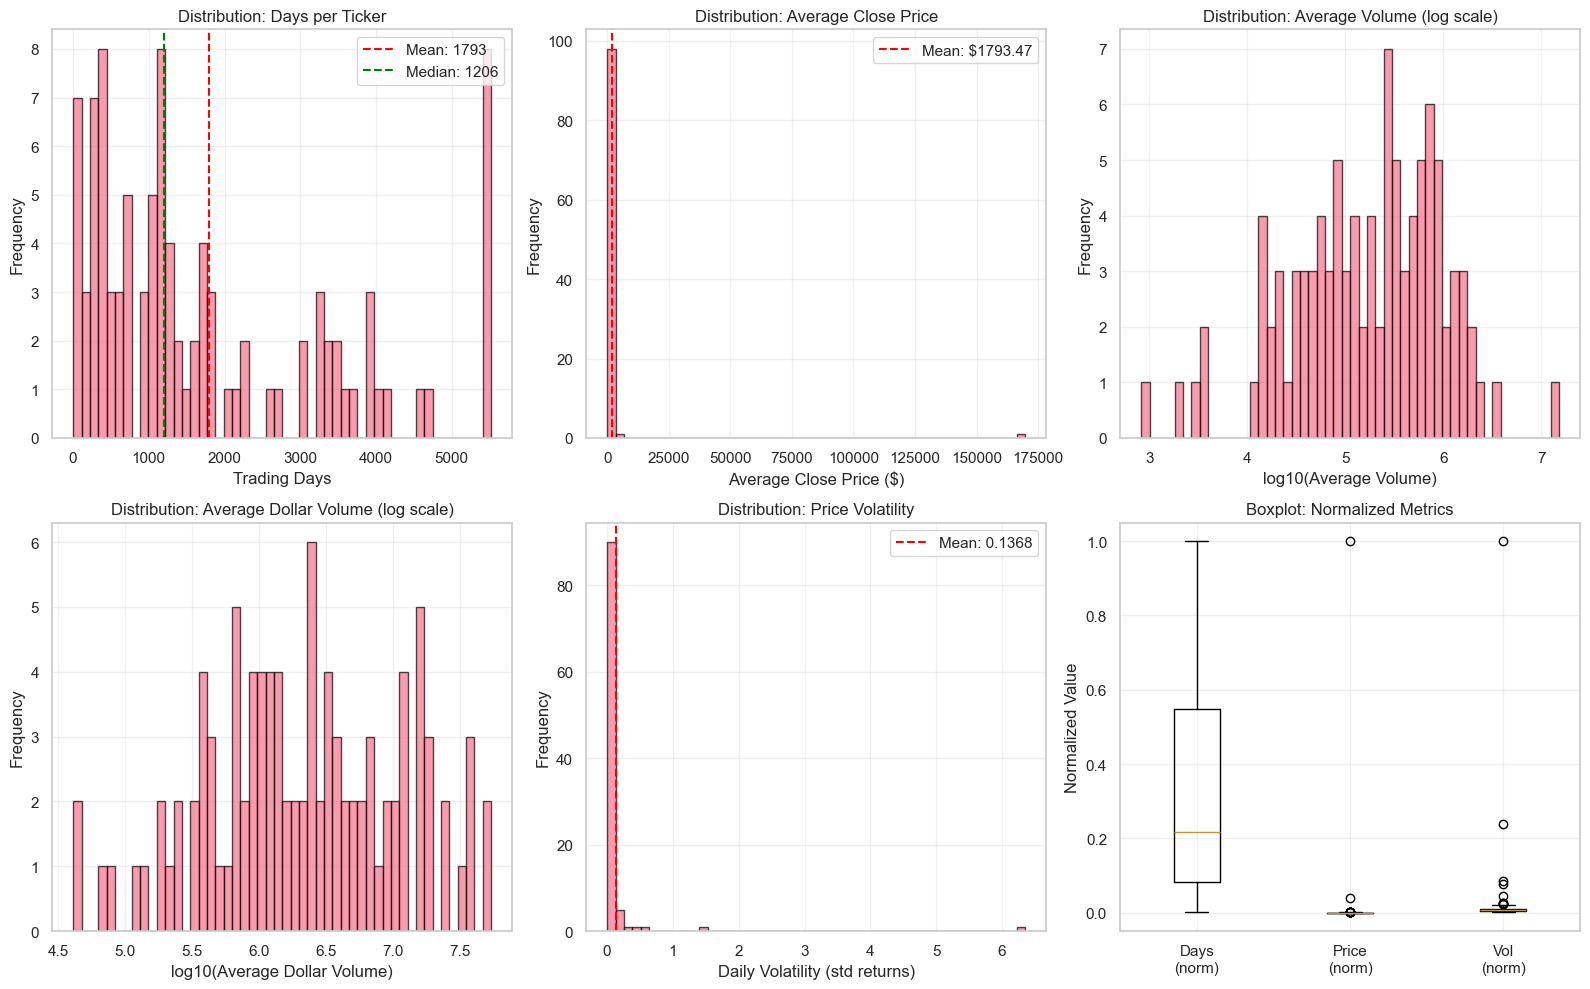

✅ Gráficos generados y guardados


In [10]:
# Visualizaciones
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Días por ticker
axes[0, 0].hist(days_per_ticker, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(days_per_ticker.mean(), color='red', linestyle='--', label=f'Mean: {days_per_ticker.mean():.0f}')
axes[0, 0].axvline(np.median(days_per_ticker), color='green', linestyle='--', label=f'Median: {np.median(days_per_ticker):.0f}')
axes[0, 0].set_xlabel('Trading Days')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution: Days per Ticker')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Precio promedio
axes[0, 1].hist(avg_close, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(avg_close.mean(), color='red', linestyle='--', label=f'Mean: ${avg_close.mean():.2f}')
axes[0, 1].set_xlabel('Average Close Price ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution: Average Close Price')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# 3. Volumen promedio (log scale)
axes[0, 2].hist(np.log10(avg_volume + 1), bins=50, edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('log10(Average Volume)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].set_title('Distribution: Average Volume (log scale)')
axes[0, 2].grid(alpha=0.3)

# 4. Dollar volume (log scale)
axes[1, 0].hist(np.log10(avg_dollar_vol + 1), bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('log10(Average Dollar Volume)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution: Average Dollar Volume (log scale)')
axes[1, 0].grid(alpha=0.3)

# 5. Volatilidad
axes[1, 1].hist(price_volatility, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].axvline(price_volatility.mean(), color='red', linestyle='--', label=f'Mean: {price_volatility.mean():.4f}')
axes[1, 1].set_xlabel('Daily Volatility (std returns)')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution: Price Volatility')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

# 6. Boxplot comparativo
axes[1, 2].boxplot([days_per_ticker / days_per_ticker.max(), 
                     avg_close / avg_close.max(),
                     price_volatility / price_volatility.max()],
                    labels=['Days\n(norm)', 'Price\n(norm)', 'Vol\n(norm)'])
axes[1, 2].set_ylabel('Normalized Value')
axes[1, 2].set_title('Boxplot: Normalized Metrics')
axes[1, 2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('D:/04_TRADING_SMALLCAPS/01_DayBook/fase_01/E_Event Detectors E1, E4, E7, E8/notebooks/distribuciones_daily_ohlcv.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Gráficos generados y guardados")

## 8. Time Series Properties

8.1 TIME SERIES ANALYSIS (3 tickers ejemplo)



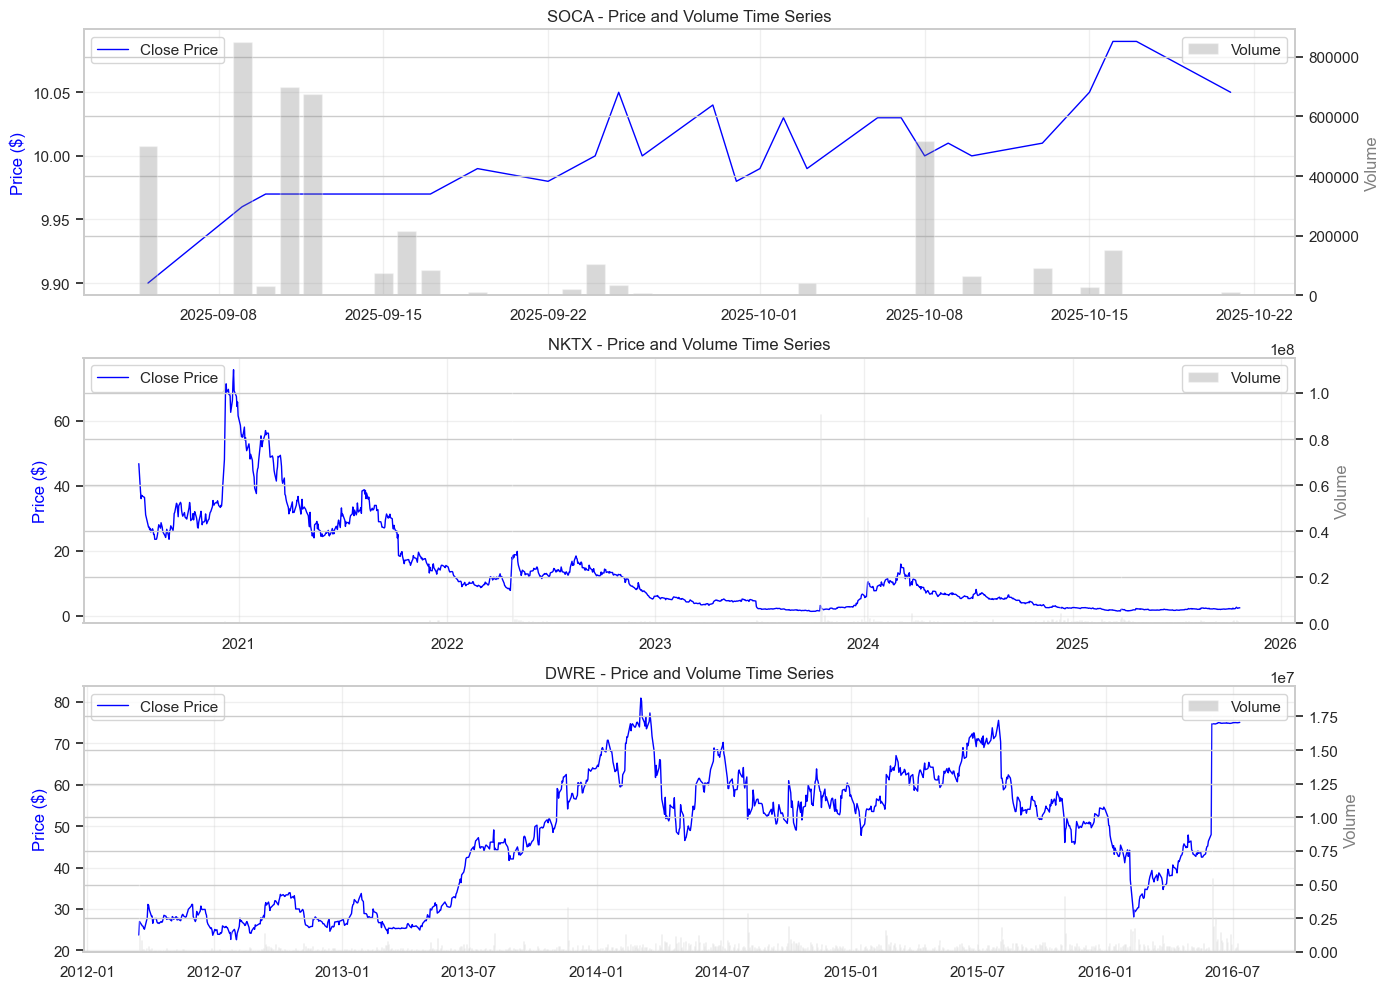

✅ Time series plots generados


In [11]:
print("=" * 80)
print("8.1 TIME SERIES ANALYSIS (3 tickers ejemplo)")
print("=" * 80)
print()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

for idx, ticker_dir in enumerate(sample_dirs):
    df = pl.read_parquet(ticker_dir / 'daily.parquet')
    ticker = ticker_dir.name
    
    # Convertir a pandas para plotting
    df_pd = df.to_pandas()
    df_pd['date'] = pd.to_datetime(df_pd['date'])
    df_pd = df_pd.set_index('date')
    
    # Plot precio y volumen
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    ax1.plot(df_pd.index, df_pd['c'], color='blue', linewidth=1, label='Close Price')
    ax2.bar(df_pd.index, df_pd['v'], color='gray', alpha=0.3, label='Volume')
    
    ax1.set_ylabel('Price ($)', color='blue')
    ax2.set_ylabel('Volume', color='gray')
    ax1.set_title(f'{ticker} - Price and Volume Time Series')
    ax1.grid(alpha=0.3)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

plt.tight_layout()
plt.savefig('D:/04_TRADING_SMALLCAPS/01_DayBook/fase_01/E_Event Detectors E1, E4, E7, E8/notebooks/time_series_daily_ohlcv.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Time series plots generados")

## 9. Resumen Ejecutivo y Recomendaciones

In [12]:
print("=" * 80)
print("EXECUTIVE SUMMARY: TRACK A DAILY OHLCV VALIDATION")
print("=" * 80)
print()
print("📊 DATASET OVERVIEW:")
print(f"  Total tickers processed: {len(ticker_dirs):,}")
print(f"  Valid tickers (with data): {with_both:,}")
print(f"  Coverage: {with_both/8620*100:.2f}%")
print(f"  Sample validation: {len(sample_stats)} tickers")
print()

print("✅ QUALITY METRICS:")
print(f"  Schema compliance: {schema_matches}/{len(sample_tickers)} ({schema_matches/len(sample_tickers)*100:.1f}%)")
print(f"  NULL values: {total_nulls:,} ({total_nulls/(total_rows*9)*100:.4f}% of all cells)")
print(f"  OHLC violations: {total_violations:,} ({total_violations/total_rows_checked*100:.4f}%)")
print(f"  Duplicate dates: {duplicate_dates}/{len(sample_quality)} tickers")
print(f"  Unordered dates: {unordered_dates}/{len(sample_quality)} tickers")
print()

print("📈 STATISTICAL SUMMARY:")
print(f"  Avg days per ticker: {days_per_ticker.mean():,.1f} ± {days_per_ticker.std():,.1f}")
print(f"  Avg price: ${avg_close.mean():.2f} (median: ${np.median(avg_close):.2f})")
print(f"  Avg volume: {avg_volume.mean():,.0f} (median: {np.median(avg_volume):,.0f})")
print(f"  Avg volatility: {price_volatility.mean():.4f}")
print()

print("🎯 RECOMMENDATIONS:")
if total_violations == 0 and total_nulls == 0:
    print("  ✅ Dataset is PRODUCTION-READY")
    print("  ✅ Proceed with Event Detectors E1, E4, E7, E8")
    print("  ✅ No data quality issues found")
else:
    print("  ⚠️  Minor issues found (see details above)")
    print("  ⚠️  Review and fix before production use")
print()

print("📋 NEXT STEPS:")
print("  1. Execute event detectors E1, E4, E7, E8")
print("  2. Create multi-event fuser")
print("  3. Generate event watchlists")
print("  4. Download ticks for detected events (±N days)")
print("  5. Build DIB/VIB bars for event-specific analysis")
print()

print("=" * 80)
print("✅ VALIDATION COMPLETED")
print("=" * 80)

EXECUTIVE SUMMARY: TRACK A DAILY OHLCV VALIDATION

📊 DATASET OVERVIEW:
  Total tickers processed: 8,617
  Valid tickers (with data): 8,617
  Coverage: 99.97%
  Sample validation: 100 tickers

✅ QUALITY METRICS:
  Schema compliance: 20/20 (100.0%)
  NULL values: 0 (0.0000% of all cells)
  OHLC violations: 0 (0.0000%)
  Duplicate dates: 0/50 tickers
  Unordered dates: 0/50 tickers

📈 STATISTICAL SUMMARY:
  Avg days per ticker: 1,793.0 ± 1,623.0
  Avg price: $1793.47 (median: $13.66)
  Avg volume: 575,099 (median: 211,015)
  Avg volatility: 0.1368

🎯 RECOMMENDATIONS:
  ✅ Dataset is PRODUCTION-READY
  ✅ Proceed with Event Detectors E1, E4, E7, E8
  ✅ No data quality issues found

📋 NEXT STEPS:
  1. Execute event detectors E1, E4, E7, E8
  2. Create multi-event fuser
  3. Generate event watchlists
  4. Download ticks for detected events (±N days)
  5. Build DIB/VIB bars for event-specific analysis

✅ VALIDATION COMPLETED
